This script generates SHAP visualizations comparing interpretability under two tokenization schemes:
(1) word-level and (2) q-gram-based representations.

Using a single tweet instance, it builds two linear classifiers—one using Bag-of-Words and the other using
character-level q-grams—then applies SHAP to explain each model's prediction.

The output consists of two comparative plots:
- The top plot shows a concise and human-readable explanation based on word-level features.
- The bottom plot highlights the interpretability challenges caused by the high dimensionality of q-grams,
  where over 100 fragmented features result in an overcrowded and unreadable explanation.

This illustrates a key limitation of post-hoc explainability methods like SHAP and LIME when applied to sparse,
fragmented feature spaces, such as those produced by q-gram tokenization.

In [ ]:
try:
    import microtc
except ImportError:
    !pip install microtc

try:
    import shap
except ImportError:
    !pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 1.9 MB/s eta 0:00:00


In [ ]:
from sklearn.svm import LinearSVC

from sklearn.model_selection import StratifiedKFold

import pandas as pd
import numpy as np

from microtc import TextModel

import shap

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

import sys
print(sys.version)

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('spanish')
txt = [[stemmer.stem(word) for word in sentence.split(" ")] for sentence in ["puto puta putote marica maricon "]]
print(txt)

stopwords.words('spanish')[:10]

[['put', 'put', 'putot', 'maric', 'maricon', '']]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [ ]:
from microtc.utils import tweet_iterator
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#fn = f"/content/drive/MyDrive/datasets/ordenados/hope_24_en_4.json"
fn = f"/content/drive/MyDrive/datasets/ordenados/meoffendes_21_sp_2.json"
#fn = f"/content/drive/MyDrive/datasets/ordenados/haha_21_sp_2.json"


tweets = list(tweet_iterator(fn))

df = pd.DataFrame(tweets, columns=['text', 'klass'])

df = df.sample(n=400)

# stopwords no me sirven para ver frecuencia de tokens
stop_words_sp = set(stopwords.words('spanish'))
#df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words_sp]))

X_train, X_test = train_test_split(df, test_size=0.10, shuffle = True)


'''
Index reset required to ensure that the index matches the crs_matrix
'''
X_train = X_train.reset_index(drop=True)

X_train.loc[43, 'text'] = '#masterchefmx y salen los putos a tener fantasias con los o chef irlandés'
print(X_train.iloc[43])

'''
TextModel - configuration
'''

token_list_u = [-1, 2, 3, 4]
textmodel_u = TextModel(token_list=token_list_u, del_diac=True,  del_dup=False, lc=True, hashtag_option=None).fit(X_train.text)
train_tokenized_original_u, test_tokenized_inmutable_ = textmodel_u.transform(X_train['text']), textmodel_u.transform(X_test['text'])

estimator_ = LinearSVC()

# uni-grams
estimator_.fit(train_tokenized_original_u, X_train.klass)
y_pred = estimator_.predict(test_tokenized_inmutable_)
f1_ctrl_u = round(f1_score(X_test.klass, y_pred, average='macro'), 5)
precis_ctrl_u = round(precision_score(X_test.klass, y_pred, average='macro'), 5)
matrix = confusion_matrix(X_test.klass.values.astype(int), y_pred)
trues_ctrl_u = np.trace(matrix)

print(f"Control: f1_crtl_u: {f1_ctrl_u},  trues_ctrl_u: {trues_ctrl_u}, falses: {len(y_pred) - trues_ctrl_u} ")



----------------- (400, 2) | [0 1] | X_train: (360, 2) | X_test: (40, 2) ----------------
text     #masterchefmx y salen los putos a tener fantasias con los o chef irlandés
klass                                                                            0
Name: 43, dtype: object
Control: f1_crtl_u: 0.70588,  trues_ctrl_u: 34, falses: 6 


In [ ]:
ss = "ayer en guadalajara feministas arrojaban ácido a católicos que protegían la catedral que quemaron mujeres católicas con esas sustancias un hombre que quiso sacarles los recipientes y le partieron bate cabeza terminó internado medios absoluto silencio chile vamos o sea centro de derecha cobarde pacto hoy el gobierno izquierdista de boric para continuar farsa del proceso constituyente acaba ser aplastada la sur una vez más que da demostrado centro de derecha no es oposición nada se está tratando de silenciar bolivia este momento grupos armados afines al han cercado santa cruz ejerciendo violencia inusitada contra su población donde están agrupaciones de derechos humanos festejando lula_usr lucia lo siento pero así he be jamás arrepintió bergoglio carta tampoco perdón asino de dedicar decir maravillosa defensora ddhh hera corrupta aliada terrorismo internacional le ejxcdio quórum eliminar impuesto tarjetas crédito liberales me gustan formas milei colombia dólar ya casi_numpesos hace muy pocos meses cuando petro fue electo estaba demasiado previsible ganó mamertos decían vellorar minisiquiera vivo allí pobres idiotas son monos navaja pedro castillo convertirse dictador derrocar lo deber político moral todo ciudadano bien toda fuerza pública respete orden democrático atención méxico 🇲🇽 próximo septiembre estar es san luis potosí espero hola quería consultarles si van a mencionar es mismo luz refieren reivindico dictaduras violaron sistemáticamente ddhh como cuba dijo haber brindado champagne produjo atentado político ciangemelas bravo recurrir gestos vacíos celebrar mes herencia latinx corporaciones izquierda pudieran realmente ayudar latinos apoyando esfuerzos reubicación migrantes batalla cultural gana firmeza cortarse pelo por irán lejos acción política acto narcisista busca likes aplausos cobertura mediática otra cosa acabo escuchar discurso gustavo onu primero pensé fake después pregunté cuántas botellas whisky habría tomado antes llegar recinto finalmente acordé sus votantes solamente pude pensar merecenguardián apatria robo junto parricidas choklender esa estafa llamada sueños compartidos nunca devolvieron centavo hicieron casas sorprender referentes que ustedes tienen definición involucrados crímenes corrupción preorden generación idiota aprovecha gran descuento invita evento privado online loca verdad biological coco creer mujer definen autopercepción hormonizar someter cirugías reasignación sexo niños abusó usted promueve esotesis propedofilia muestran cuán equivocados estaban extremo centro totalmente ciegos ideología tornaron cómplices incluso promotores pueden acusarnos conspiranoicos nosotros señalaremos útiles pues refieren ningún lugar ninguna falta me rareivindicación eta num farce zln atentados al qaeda además enemiga iglesia mayra google e encontré esto millones dólares donados organizaciones globalistas anticatólicas derecho decidir entre ellas ford foundation red clínicas abortistas ippf solo nombre alberto fernández dice jugadores fueron casa rosada porque cansados quien cree engaña simplemente dejaron utilizar políticamente corruptos delincuentes revivió pinochet inmensa mayoría pueblo plebiscito rechazó texto constitucional liberticida vergonzoso cínico bruto actual constitución chilena reformada numerosas veces democracia diversidades forma favorita contemporáneo llamar realidad sigue significando anormales efecto nuevo quieren allá salen orma diablos correctos apretando jueces cadena nacional pocas horas cristina kirchner condenada desesperados vos traes tristezas frustraciones maldad argentinos os parte buena suerte a no te vás hashtag único español invitado rusia observador referéndum donbás llevaron móviles frente zelenski hitler también unas elecciones votaciones rocambolescas corruptas afganistán valía urgente pregunta tropas mos cuenta rontu colaboraste rusos balacura prorruso dilema ucrania colaboracionistas detectado ⁦_usr⁩ ultras rinamurio jimmy buscan pactar evitar peñas cárcel multas altas fiscalía propone sanciones mínimas num € acusados prefieren asumir abrir puerta ley deporte algunas claves policía seguía desde días jubilado cartas colaboraba alguien monitorizaron pasos antes sospecha celebrar alguna reunión interés investigadores creen tras registro pretendía hacer envíos 🔴 delegado c eutaculpa marlas ka interior retorno menores recibió órdenes mateos confesó juez plan ilegal impulso marruecos ministro madrid atleti buenos amigos placer siempre colaborar mejor revista kiosko diez años contando historias fútbol sin olvidar grada rubiales real madrid sevilla vernos cepillamos palangana caen mal nuevos mensajes presidente tantos muertos pesima gestión pandemia viene calificar monumento derecho homenaje fallecidos familiares deberían pedir renuncia inmediata animal muchas gracias javi mucha responsabilidad libro rinde culto previa hecho largas acabe resaca boca plata partido aplazado incidentes hincha gimnasia da pasó medio proclamarse campeón último bombonera independiente racing todavía juega river plate joven mexicana acusa exedil ourense amenazarla esferas políticas denuncia investigaré recogió docena agresiones físicas cuenta chica escapó ayudatía exconcejal political_party arrestos aid badaoui líder islámico cataluña abre independentismo islamofobia tiene fotos políticos congreso unos peligrosos alafista otros activista aquí caso escrito defensora grava pulso gabilondo íntegro rechazado todas recomendaciones eleva persona rebate argumentos foro económico mundial estructura plutocrática global ha comprado izquierdas occidentales banderitas multicolor agendas dietas veganas punos final zurdos terminaron siendo mejores empleados poder plutocrático dialogará un num % diciendo sabe cada diálogo corren hacia trata juego mi rendesgraciado arrinconado profesor sierra corrupto día claro todos siglo xxi cartel tratan cubrirse espaldas ellos cumplen muerte billy bremmer escocés capitaneo temido leeds milito cluba que equipo duro llevado cine the damned united basada novela homónima king interpretó actor stephen graham aquí recibió reconocimiento costa rica 🇨🇷 banca da nueva república inmenso honor agradezco diputados espacio especialmente video razones favor bolsonaro quienes difunden menos chicago tribune extensa entrevista uno periodistas hizo hablamos socialismo américa latina hasta pasando feminismo aborto cultura cancelación increíble aunque lleva cargo republicana popular socialista alexandria ocasio cortez hispanos estadounidenses conocen según encuesta ánimo querido hay impulsar rd grieta puede cerrar asumir la tenes hijo kdeja financiar lo comercio cierra tus puertas militantes empleador contrata sira hi cortar vínculo estas ratas parece progres biológicamente analfabetos estados unidos utilizan lenguaje orwelliano deshumanizar bebés fin justificar posturas radicales nacimientos señor bebé cuerpo cosas demócratas existen países hombres embarazados cerebro kamala harris compañera formula charlie crist jefa sindical dos caras legado fidel castro menosprecia veteranos perder florida desantis barreras suelo mismo sin cumplieron acuerdo paz noviembre prometieron chilenos traidores les respondieron crea abismo dirigentes bases apruebo meten bandera boba confundida entender llama por no terrorismo explicado negro eran inventos míos ministra minas irene vélez inútil ocupa poco tiempo manera sobrada formación ocupar importantísima cartera cae solito desastre familia cometer popularidad opción intentar golpe estado aplauso votaron indica habrá tsunami mirojo nocheserá esencial victoria liberal progress en closet apoyan explícitamente silva brasil confirma venimos resentidos sociales infiltrados china mantiene esclavizada cuenta covid num violaciones intensifican mientras tanto esfuerzan hablar aquello protegiendo aceptar + sean estamos hablando tema terrestral cuba violan sistemática embargo dado importancia revolución justifica dictadores llaman revolucionarios asesinos guerrilleros universidad aprobado defensa pedofilia peor abundan errores académicos interpretación absurda emilio rousseau ejemplo analizo biden aliviar préstamos estudiantiles dividido alienado aumentará gastos matrículas sido exitoso 😂 fui distinguido medalla perú 🇵🇪 manes impresionante capacidad absolutamente concreto minutos pantalla indignados pide afirman existencia num mil desaparecidos brinden lista esos supuestos indignarse incómodo mentirosos expuestos tan flagrantes mañana feria num hsfirma libros área conferencias alondifundir republicanos acaban obtener resultado legislativas invito leer memorandum estuve recientemente programa tuvo precisa destrozar rodio saananavarrodirecto cnn llamó conveniencia cara pierdas interés ante elegidos"
t = textmodel_u.tokenize(ss)
print(len(t))

1120


In [ ]:
# “#masterchefmx y salen los putos a tener fantasias con los o chef irlandés”

X_train.loc[43, 'text'] = '#masterchefmx y salen los putos a tener fantasias con los o chef irlandés'
X_train.iloc[43]

,43
text,#masterchefmx y salen los putos a tener fantasias con los o chef irlandés
klass,0


In [ ]:

'''
misclassified
'''

# Las Klasses tienen que ser una secuencia continua y ordenada: 0, 1, 2, 3...
klasses = X_train.klass.unique()
klasses.sort()

'''
    MissClassified
'''

misclassified = {}
for kl in klasses:
    misclassified[kl] = []

false_positive_idxs, false_negative_idxs = [], []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_index, val_index in skf.split(X_train.text, X_train.klass):

    # fold
    train_fold = X_train.iloc[train_index].copy()
    val_fold = X_train.iloc[val_index].copy()

    # Crear el LSVC
    # comprovado, no requerido
    #estimator_kfold = LinearSVC(verbose=0)

    # Tokenizar el Fold de entrenamiento en turno
    train_fold_tokenized = textmodel_u.transform(train_fold.text.values.astype(str))
    # Entrenar con el Fold de entrenamiento en turno
    estimator_.fit(train_fold_tokenized, train_fold.klass.values.astype(int))
    # Tokenizamos el vald_fold
    val_fold_tokenized = textmodel_u.transform(val_fold.text.values.astype(str))
    # Predecir con el val Fold tokenizado
    y_pred_fold = estimator_.predict(val_fold_tokenized)

    #matrix = confusion_matrix(val_fold.klass.values.astype(int), y_pred_fold)
    #tn_val, fp_val, fn_val, tp_val = matrix.ravel()
    #ff = ff + fn_val + fp_val
    #print(fp_val, fn_val, fn_val + fp_val, ff)
    #print(matrix)

    # extrar el arreglo de predicciones para el Fold en turno
    predicciones = [(X_index, input, y_true, y_pred) for row_index, (X_index, input, y_true, y_pred) in enumerate(zip (val_fold.index, val_fold.text.values.astype(str), val_fold.klass.values.astype(int), y_pred_fold))]
    #falses_predicciones = [p for p in predicciones if p['y_true'] != p['y_pred']]
    ds_predicciones = pd.DataFrame(predicciones, columns=['X_index', 'text', 'y_true', 'y_pred'])
    # importante. X_index lleva/conserva el mismo índice que el X_train
    ds_predicciones.set_index('X_index', inplace=True)

    ds_falses_predicciones = ds_predicciones[ds_predicciones['y_true'] != ds_predicciones['y_pred']] ###.copy()
    #print('Predicciones Falsas Totales: ', ds_falses_predicciones.shape[0], '   en ', ds_falses_predicciones.y_pred.unique())

    # Acmular los indices de los misclassifieds por klass
    for kl in klasses:
                       # ds_falses_predicciones contiene solo las falsas (pred != true). Significa que la pred esta mal. Entonces, acumulo las mal pred por klase.
        falses_kl_df = ds_falses_predicciones[ds_falses_predicciones['y_pred'] == kl] # de los falsos, recorro los que yo dije que eran de otra clase
        #print(kl, falses_df.shape[0], falses_df.y_pred.unique())
        #print(falses_df)
        try:
            falses_idxs = np.unique(np.concatenate([misclassified[kl], falses_kl_df.index.values]))
            misclassified[kl] = falses_idxs.astype(int)
            #print(f"k: {kl}, lenFalIdxsDeClase: {len(falses_idxs)}, AcumuladoDeClase: {len(self.misclassified[kl])}" )
            misclassified[kl] = list(dict.fromkeys(misclassified[kl]))
        except Exception as e:
            print(e)


print(len(misclassified[0]), len(misclassified[1]))

88 5


In [ ]:
# feature_names, explainer & shap_values con train_tokenized_original_u

feature_names = list(textmodel_u.id2token.values())
explainer = shap.Explainer(estimator_, train_tokenized_original_u, feature_names=feature_names)
shap_values = explainer(train_tokenized_original_u) # shap._explanation.Explanation

In [ ]:
print(f"Control: f1_crtl_u: {f1_ctrl_u},  trues_ctrl_u: {trues_ctrl_u}, falses: {len(y_pred) - trues_ctrl_u} ")

Control: f1_crtl_u: 0.48052,  trues_ctrl_u: 28, falses: 12 


In [ ]:
train_tokenized_original_u

<360x1862 sparse matrix of type '<class 'numpy.float64'>'
	with 5296 stored elements in Compressed Sparse Row format>

In [ ]:
matrix = train_tokenized_original_u
row_i = 359
row_start = matrix.indptr[row_i]
row_end = matrix.indptr[row_i + 1]
row_values = matrix.data[row_start:row_end]
row_columns = matrix.indices[row_start:row_end]

print(row_values)
print(row_columns)
tokens = [textmodel_u.id2token[i] for i in row_columns]
print(tokens)

X_train.iloc[row_i]

[0.08696798 0.30986884 0.30986884 0.30986884 0.30986884 0.19419786
 0.04972036 0.23688858 0.27337871 0.09092805 0.30986884 0.08188114
 0.12676421 0.30986884 0.11837127 0.04075268 0.27337871 0.30986884
 0.06193971 0.15486141]
[  65  111  147  157  257  422  464  509  521  558  711 1014 1115 1151
 1238 1358 1480 1573 1805 1810]
['_usr', 'aire', 'angela', 'apaguen', 'cab', 'cosas', 'de', 'dicen', 'digo', 'el', 'gachos', 'me', 'no', 'oigan', 'pero', 'que', 'sean', 'tambor', 'y', 'yo']


,359
text,"@usuario yo tambor pero digo oigan no sean cab.... gachos apaguen el aire no y me dicen de cosas angela , que…"
klass,0


In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

train_tokenized_target_csr = train_tokenized_original_u.copy()

shaps_values_array = explainer.shap_values(train_tokenized_original_u.toarray())

base_row = shap_values.base_values[0]

for f in  [-1.25, -1.1, -0.9, -0.83, -0.8, 0.785, -0.75, -0.6, -0.5, 0, 0.5, 0.9, 1.25, 1.5, 1.75, 2.0, 2.25, 5.5]:
    for kl in klasses:
        for row_i in range(train_tokenized_target_csr.shape[0]): # simplemente un consecutivo de 0 a n (0,1,2,3,..,n)
            row_start = train_tokenized_target_csr.indptr[row_i]
            row_end = train_tokenized_target_csr.indptr[row_i + 1]
            row_values = train_tokenized_target_csr.data[row_start:row_end]
            row_columns = train_tokenized_target_csr.indices[row_start:row_end]

            # Buscar y modificar el elemento específico si se encuentra en la fila y columna objetivo
            if row_i in misclassified[kl]:

                #print(row_i, row_columns) #X_train.iloc[row_i].text, tweet_vector_)


                shaps_values_row = shaps_values_array[row_i]
                sum_row  = sum(shaps_values_row)
                #klass_row = 1 if (sum_row + base_row) > 0.4999 else 0
                klass_row = 1 if (sum_row + base_row) < 0 else 0
                #print(row_i, base_row, sum_row,  (sum_row + base_row, klass_row))

                if klass_row == 0:
                    filtered_shap_values =  [i for i in row_columns if shaps_values_row[i] > 0] # media]
                else:
                    filtered_shap_values =  [i for i in row_columns if shaps_values_row[i] < 0] # media]

                #filtered_shap_values =  [i for i in row_columns.shape[0, kl] if shaps_values_row[i, kl] > 0.01]

                #print(np.nonzero(shaps_values_row))
                #print(filtered_shap_values)

                for j, col in enumerate(row_columns):
                    if col in filtered_shap_values:
                        train_tokenized_target_csr.data[row_start + j] = train_tokenized_target_csr.data[row_start + j] *  f # csr_mat.data[row_start + j]  * -1
                        #print(f"{row_i} : {col} -> {train_tokenized_target_csr.data[row_start + j]}")


    estimator_.fit(train_tokenized_target_csr, X_train.klass)
    y_pred = estimator_.predict(test_tokenized_inmutable_)
    f1_ctrl_u = round(f1_score(X_test.klass, y_pred, average='macro'), 5)
    precis_ctrl_u = round(precision_score(X_test.klass, y_pred, average='macro'), 5)
    matrix = confusion_matrix(X_test.klass.values.astype(int), y_pred)
    trues_ctrl_u = np.trace(matrix)

    print(f"{f} :: Control: f1_crtl_u: {f1_ctrl_u},  trues_ctrl_u: {trues_ctrl_u}, falses: {len(y_pred) - trues_ctrl_u} ")

In [ ]:
shap_values.base_values

array([-0.29878257, -0.29878257, -0.29878257, ..., -0.29878257,
       -0.29878257, -0.29878257])

In [ ]:
shaps_values_array.shape, shaps_values_row.shape

((480, 3846, 4), (3846, 4))

In [ ]:
binario.shape, multiple.shape

((2290,), (3883, 4))

In [ ]:
X_train.iloc[81].text

'gorda metabolismo aceleró'

In [ ]:
for i in range(train_tokenized_target_csr.shape[0]):
    row_start = train_tokenized_target_csr.indptr[i]
    row_end = train_tokenized_target_csr.indptr[i + 1]
    row_values = train_tokenized_target_csr.data[row_start:row_end]
    row_columns = train_tokenized_target_csr.indices[row_start:row_end]

    for value, col in zip(row_values, row_columns):
        if value < 0:  # Filtrar para mostrar solo valores menores a -1
            print(f"Fila {i}, Columna {col}, Valor {value}")

In [ ]:
feature_names = list(textmodel_u.id2token.values())
explainer = shap.Explainer(estimator_, train_tokenized_original_u, feature_names=feature_names)
shap_values = explainer(train_tokenized_original_u) # shap._explanation.Explanation

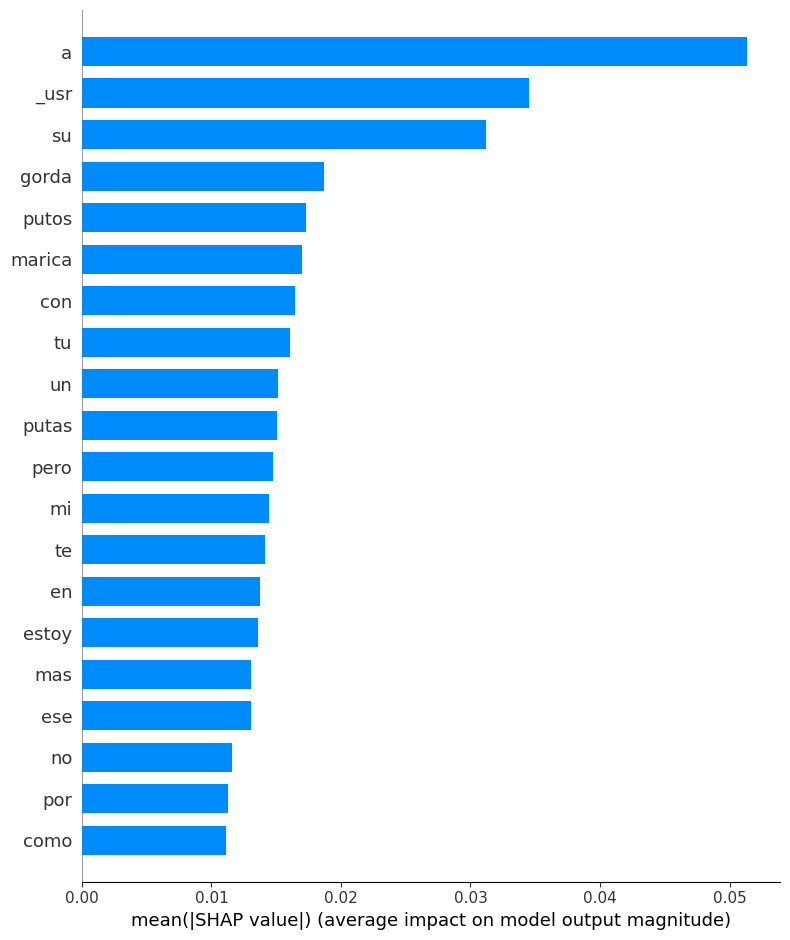

In [ ]:
shap.summary_plot(shap_values, train_tokenized_original_u, plot_type="bar")

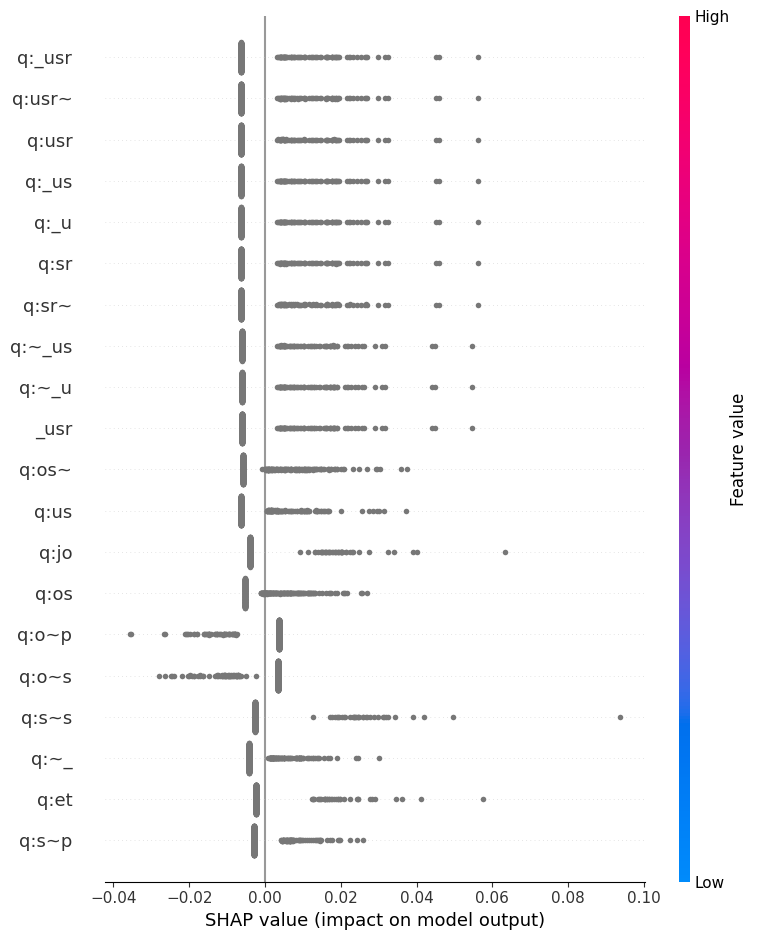

In [ ]:
shap.summary_plot(shap_values, train_tokenized_original_u)
#shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0, :], matplotlib = True)

In [ ]:
# shap_values[1] # regresa los shap_values del row indicado
# shap_values[1].data # contiens los valores no-zero.
# shap_values[10][110].values # el shap_value especifico


In [ ]:
tweet_idx = 43 # 3992 es el num de row, y yienes que ser la columna Index
X_train.iloc[tweet_idx]

,43
text,#masterchefmx y salen los putos a tener fantasias con los o chef irlandés
klass,0


In [ ]:
X_test[X_test.text.str.contains('pinole')], X_train[X_train.text.str.contains('pinole')]

(Empty DataFrame
 Columns: [text, klass]
 Index: [],
 Empty DataFrame
 Columns: [text, klass]
 Index: [])

In [ ]:
len(features_present)

201

In [ ]:
### Extraer los tokens del tweet específicado y filtrarlo por los no-zero

tweet_idx = 43

tweet_vector_ = train_tokenized_original_u[tweet_idx] # regresa un 'sparse matrix' de 1xd correspondiente al tweet_idx indicado que va de 0,1,2...n tweets.
features_present = tweet_vector_.nonzero()[1] # el 0 regresa puros 0, pero el 1 tiene los valores. El num de elementos corresponde al num de nonzeros
print(features_present)
#for i in features_present:
#    print(textmodel_.id2token[i])


my_shaps = explainer.shap_values(train_tokenized_original_u.toarray())[tweet_idx]
filtered_shap_values =  { f"{i}:{textmodel_u.id2token[i]}" : my_shaps[i] for i in features_present}


#filtered_shap_values =  { f"{i}:{textmodel_u.id2token[i]}" : shap_values[1][i].values for i in features_present}

# Visualizar los resultados
print(f"SHAP values para características en el tweet #{tweet_idx}:")
for feature, value in filtered_shap_values.items():
    print(f"{feature} | {value} | {value} " )
    #print(f"{feature:>20} | {value:+3.2f} | {value:+3.8f} " ) # {feature}: {round(value, 2)} : {round(value, 6)}")

# 1742 0.48162619

[  20   52  293  355  659  876  961 1155 1410 1515 1639 1829]
SHAP values para características en el tweet #43:
20:#masterchefmx | -0.098100414807945 | -0.098100414807945 
52:a | 0.022875636921431654 | 0.022875636921431654 
293:chef | -0.10711490343946875 | -0.10711490343946875 
355:con | 0.0030388387730056247 | 0.0030388387730056247 
659:fantasias | -0.10711490343946875 | -0.10711490343946875 
876:irlandes | -0.10711490343946875 | -0.10711490343946875 
961:los | 0.14324687558915464 | 0.14324687558915464 
1155:o | -0.09718179481200674 | -0.09718179481200674 
1410:putos | 0.1444848220495838 | 0.1444848220495838 
1515:salen | 0.03363824904182725 | 0.03363824904182725 
1639:tener | -0.100350618012471 | -0.100350618012471 
1829:y | 0.017343404102791646 | 0.017343404102791646 


In [ ]:
tweet_vector_

<1x13185 sparse matrix of type '<class 'numpy.float64'>'
	with 201 stored elements in Compressed Sparse Row format>

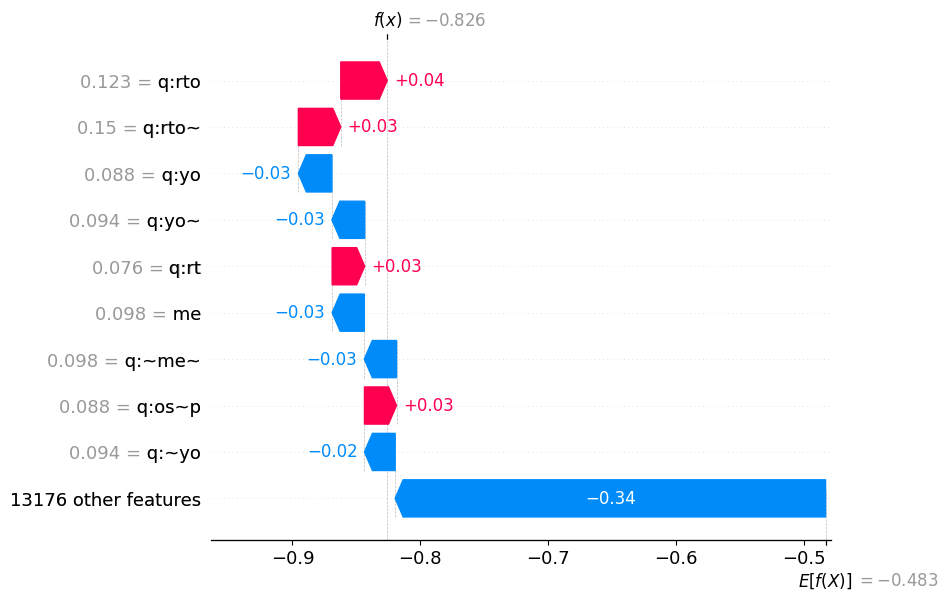

In [ ]:
shap.initjs()
shap.plots.waterfall(shap_values[1], max_display=10)


In [ ]:
len(shap_values[0])

1888

In [ ]:
v = train_tokenized_original_u[tweet_idx]
v.data

array([0.38498788, 0.44429111, 0.40960094, 0.27780589, 0.10300768,
       0.50359434, 0.33710912, 0.14644846, 0.10066352])

In [ ]:
X_train.iloc[43]

,43
text,"ni hablar, no se puede chiflar y comer pinole."
klass,0


* WaterFall

7 | madre mia tengo que lavar trastes 🍴🍸🍳😪😥


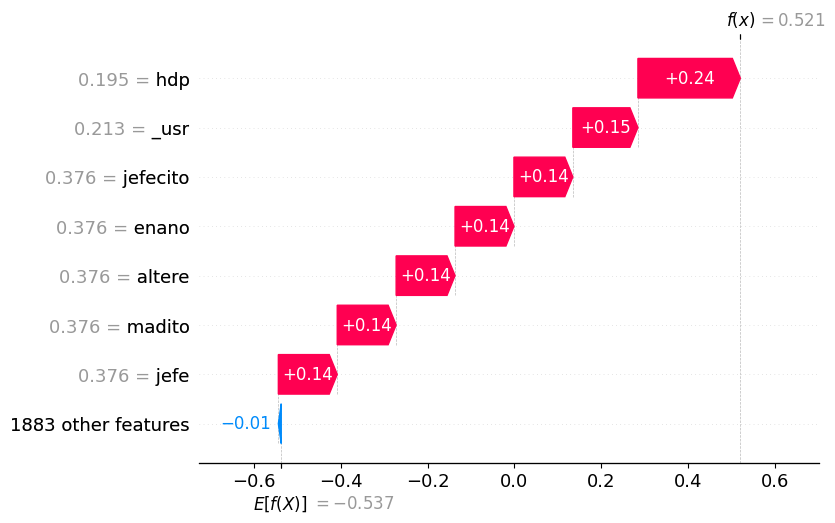

In [ ]:
tweet =  X_train.iloc[43].text # X_train[tweet_idx:tweet_idx+1].text.values[0]
words = tweet.split()
print(f"{len(words)} | {tweet}")
shap.plots.waterfall(shap_values[80], max_display=len(words)+1)

In [ ]:
my_shaps = explainer.shap_values(train_tokenized_original_u.toarray())[tweet_idx]
filtered_shap_values =  { f"{i}:{textmodel_u.id2token[i]}" : my_shaps[i] for i in features_present}

# Visualizar los resultados
print(f"SHAP values para características en el tweet #{tweet_idx}:")
for feature, value in filtered_shap_values.items():
    print(f"{feature}: {round(value, 2)}")

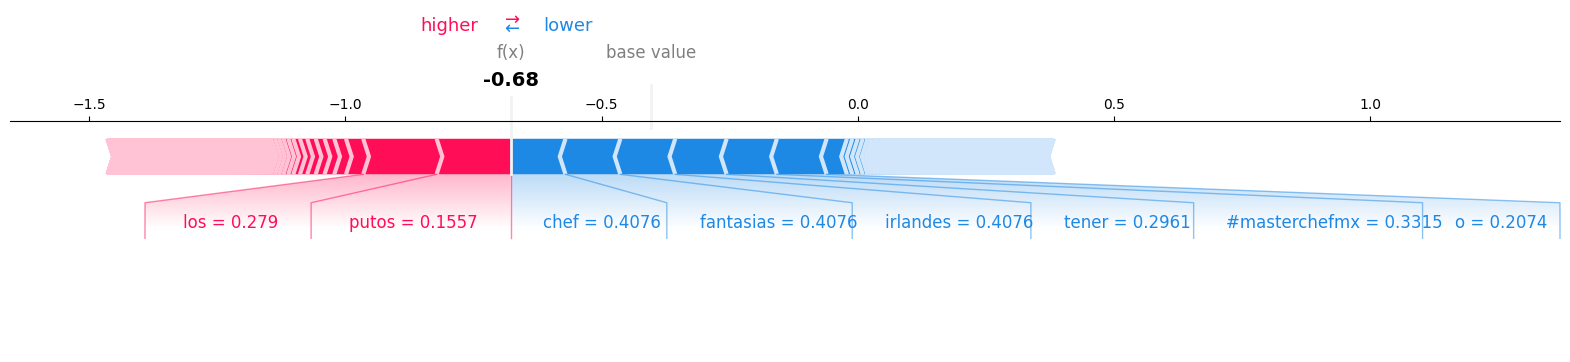

In [ ]:
my_shaps = explainer.shap_values(train_tokenized_original_u.toarray())[tweet_idx]
arr =  train_tokenized_original_u.toarray()[tweet_idx]
arr = np.round(arr, 4)
shap.initjs()  # Inicializa JS para visualizaciones en Jupyter
shap.force_plot(
                explainer.expected_value,
                my_shaps, # shap_values[0],
                arr
                #train_tokenized_original_u.toarray()[tweet_idx]
                , feature_names=feature_names, matplotlib = True)

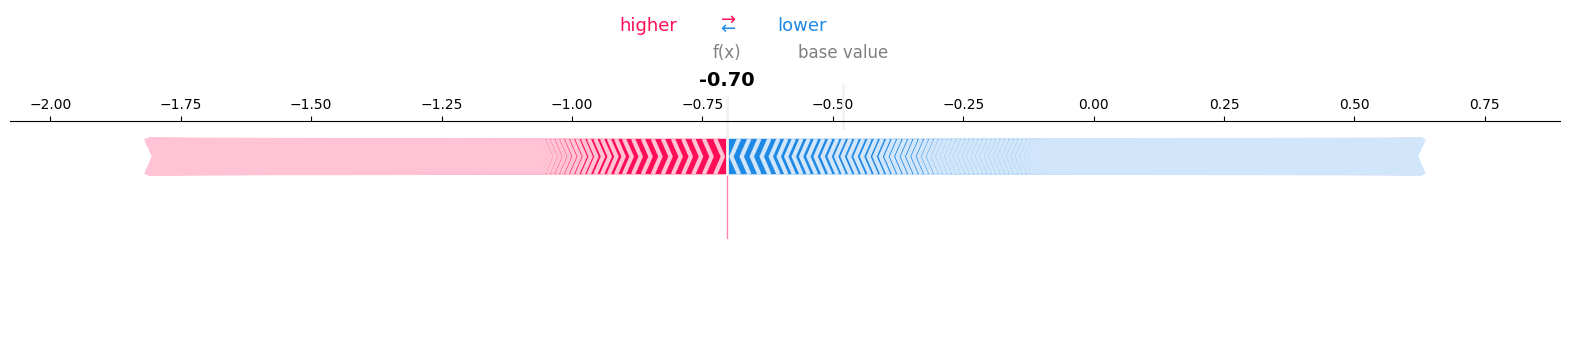

In [ ]:
my_shaps = explainer.shap_values(train_tokenized_original_u.toarray())[tweet_idx]
arr =  train_tokenized_original_u.toarray()[tweet_idx]
arr = np.round(arr, 4)
shap.initjs()  # Inicializa JS para visualizaciones en Jupyter
shap.force_plot(
                explainer.expected_value,
                my_shaps, # shap_values[0],
                arr
                #train_tokenized_original_u.toarray()[tweet_idx]
                , feature_names=feature_names, matplotlib = True)

In [ ]:
my_shaps[3613]

-0.11269159683134931